In [1]:

#Here come my imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM,Input, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Using this reference. Thank you, Jason Brownlee
https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

In [2]:
# fix random seed for reproducibility
tf.random.set_seed(55)
#Load data
month_df=pd.read_csv('monthly_energy_consumption.csv',index_col=[0])
month=month_df.values.astype('float32')
#scaling data
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(month)
#Splitting train and test: 2017 and 2018 will be test
test_size=len(month_df[month_df.index>='2017'])
train_size=int(len(dataset)-test_size)
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]
##making sure that I have numpy arrays to work with
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


# LSTM Network for Regression

In [3]:
look_back=1
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays. This is the most confusing part.
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1])) 

# create, compile and fit the LSTM network
model = Sequential()
model.add(Input(shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0,validation_data=(testX, testY), shuffle=False)

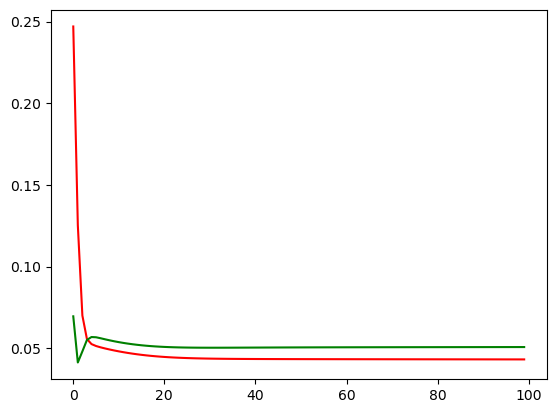

In [4]:
plt.plot(my_model.history['loss'],color='r');
plt.plot(my_model.history['val_loss'],color='g');

In [5]:
for a,b in enumerate(zip(my_model.history['loss'],my_model.history['val_loss'])):
    #print(b)
    if b[1]>b[0]:
        print(a+1, b)
        break


5 (0.052601054310798645, 0.05691391974687576)


In [6]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
best_score=1_000_000_000
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 952287.57 RMSE
Test Score: 1036180.99 RMSE
We have a new winner: 1_036_181


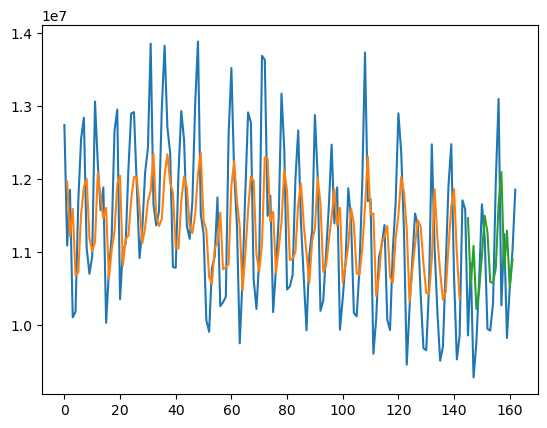

In [7]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Using Window Method


In [8]:
# It is about changing the lookback value up to 3
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
trainX = np.reshape(trainX,(trainX.shape[0],1,trainX.shape[1]))
testX = np.reshape(testX,(testX.shape[0],1,testX.shape[1])) 
# create and fit the LSTM network
model = Sequential()
model.add(Input( shape=(1, look_back)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0,validation_data=(testX, testY))

In [9]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore_lookback_2 = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Train Score: 805655.33 RMSE
Test Score: 1036180.99 RMSE
Nothing changed


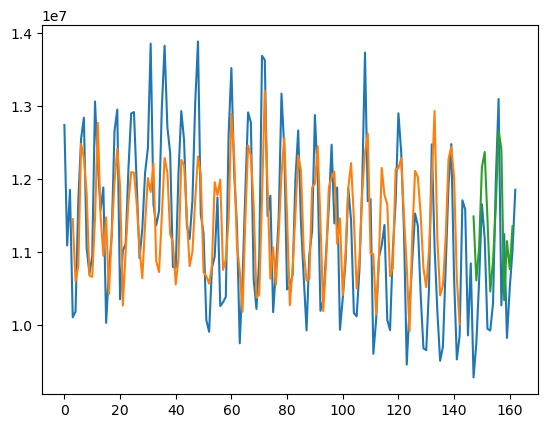

In [10]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## Using Time steps

In [11]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

model = Sequential()
model.add(Input(shape=(look_back,1)))
model.add(LSTM(4))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
my_model=model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0,validation_data=(testX, testY))

In [12]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 804395.25 RMSE
Test Score: 1125915.53 RMSE
Nothing changed


## using Memory between batches or (stateful)

In [14]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True))  #We add stateful as True as we remember the previuos state
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0,validation_data=(testX, testY),shuffle=False)
    #model.reset_state()

In [15]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 330us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 388us/step
Train Score: 685622.72 RMSE
Test Score: 950694.61 RMSE
We have a new winner: 950_695


## Stacked LSTMs with Memory Between Batches

In [16]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True,return_sequences=True))
model.add(LSTM(4,stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=0,validation_data=(testX, testY),shuffle=False)
    #model.reset_states()

In [17]:
trainPredict = model.predict(trainX, batch_size=batch_size)
#model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

140/140 ━━━━━━━━━━━━━━━━━━━━ 0s 394us/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step
Train Score: 700852.01 RMSE
Test Score: 882057.04 RMSE
We have a new winner: 882_057


# MORE THINGS WITH LSTM
Combining things that work the best not to get the best forecast

In [19]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
print(trainX.shape)
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 
model=Sequential()
model.add(Input(shape=(trainX.shape[1],1)))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=10, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
my_model=model.fit(trainX, trainY, epochs=50,batch_size=32,verbose=0,validation_data=(testX, testY))

(140, 3, 1)


In [20]:
trainPredict = model.predict(trainX)
#model.reset_states()
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict[:,0])
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict[:,0])
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Train Score: 1258194.02 RMSE
Test Score: 1023917.45 RMSE
Nothing changed


In [26]:
results=pd.read_csv('scores.csv',index_col=0)
results.loc['LSTM']=best_score/1_000_000
results.sort_values('rmse_per_million').to_csv('scores.csv')
##LSTM got the thirsd position
results.sort_values('rmse_per_million')

,rmse_per_million
XGboost,0.434517
prophet,0.571666
holt_winter,0.580689
RandomForest,0.631570
LSTM,0.882057
holt_linear,0.938474
moving_average,0.944048
arima,0.949438
SES,0.974247
simple_average,1.122177
